# Testing Notebook

In this notebook, various functionalities of the developed Gaussian Process class are tested.

In [1]:
# Get path right
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\GaussianProcess")

import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Import GP interpolation module
from GPInterpolator import GPInterpolator

%matplotlib inline

## 1. Test GP interpolation ability

In [10]:
GP = GPInterpolator(trend='Quadratic', verbose=True)

In [11]:
# Check default attributes
GP.__dict__

{'verbose': True,
 'n_restarts': 10,
 'optimizer': 'L-BFGS-B',
 'init_point': None,
 'kernel': 'Gaussian',
 'trend': 'Quadratic',
 'nugget': 1e-10}

### 1.1 Create 1D test

In [4]:
# Define test function
def Test_1D(X):
    """1D Test Function"""
    
    y = (X*6-2)**2*np.sin(X*12-4)
    
    return y

In [5]:
# Training data
X_train = np.array([0.0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1]).reshape(-1,1)
y_train = Test_1D(X_train)

# Testing data
X_test = np.linspace(0.0, 1, 100).reshape(-1,1)
y_test = Test_1D(X_test)

In [12]:
# Fit GP model
GP.fit(X_train, y_train)

Iteration 1: Likelihood=35.464935147835746 

Iteration 2: Likelihood=9.156683988740154 

Iteration 3: Likelihood=9.156683988740053 

Iteration 4: Likelihood=9.156683988740053 

Iteration 5: Likelihood=9.156683988740053 

Iteration 6: Likelihood=9.156683988740053 

Iteration 7: Likelihood=9.156683988740049 

Iteration 8: Likelihood=9.156683988740046 

Iteration 9: Likelihood=9.156683988740046 

Iteration 10: Likelihood=9.156683988740046 



In [13]:
# GP model predicting
y_pred, y_pred_SSqr = GP.predict(X_test)

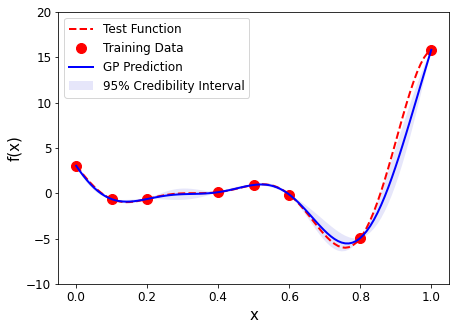

In [14]:
# Assess prediction results
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.plot(X_train,y_train,'ro',markerfacecolor='r', markersize=10, label='Training Data')
ax.plot(X_test,y_pred,'b-', lw=2, label='GP Prediction')
ax.fill_between(X_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender',label='95% Credibility Interval')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])
ax.legend(loc="upper left",prop={'size': 12});

In [15]:
GP.score(X_test, y_test)

0.9681640350494396

### 1.2 Create 2D test

In [16]:
# 2D Test function
def Test_2D(X):
    """2D Test Function"""
    
    y = (1-X[:,0])**2 + 100*(X[:,1]-X[:,0]**2)**2
    
    return y

Generate training and testing samples

In [22]:
# Training data
sample_num = 25
lb, ub = np.array([-2, -1]), np.array([2, 3])
X_train = (ub-lb)*lhs(2, samples=sample_num) + lb

# Compute labels
y_train = Test_2D(X_train).reshape(-1,1)

# Test data
X1 = np.linspace(-2, 2, 20)
X2 = np.linspace(-1, 3, 20)
X1, X2 = np.meshgrid(X1, X2)
X_test = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
y_test = Test_2D(X_test)

Demonstrate training samples in 2D space

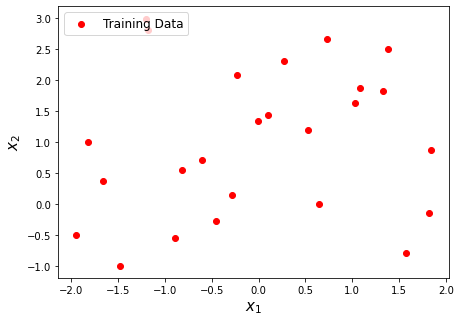

In [12]:
# Vislauzing training samples
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(X_train[:,0], X_train[:,1], c='r', label='Training Data')
ax.set_xlabel(r'$x_1$', fontsize=15)
ax.set_ylabel(r'$x_2$', fontsize=15)
ax.legend(loc="upper left",prop={'size': 12});

In [23]:
# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GPInterpolator(trend='Linear', n_restarts=20))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('GP',
                 <GPInterpolator.GPInterpolator object at 0x0000025EF75967F0>)])

In [24]:
# GP model predicting
y_pred, y_pred_SSqr = pipe.predict(X_test)

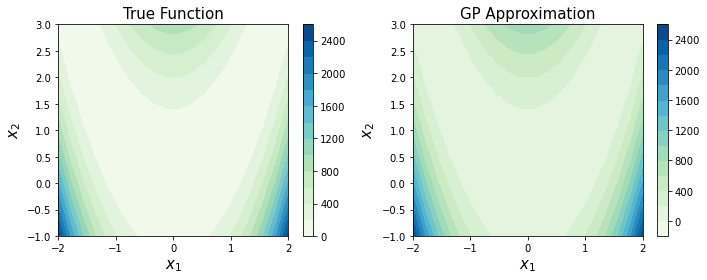

In [25]:
# Post-processing - Contour plot
fig, ax = plt.subplots(1, 2, figsize=(10,4))
title = ['True Function', 'GP Approximation']
display_y = [y_test, y_pred]

for i in range(2):
    h = ax[i].contourf(X_test[:,0].reshape(20,-1), 
                   X_test[:,1].reshape(20,-1), 
                   display_y[i].reshape(20,-1), levels=15, cmap='GnBu');
    ax[i].set_xlabel(r'$x_1$', fontsize=15)
    ax[i].set_ylabel(r'$x_2$', fontsize=15)
    ax[i].set_title(title[i], fontsize=15)
    fig.colorbar(h, ax=ax[i])
plt.tight_layout()

In [26]:
# Assess accuracy score
pipe.score(X_test, y_test)

2.489068643585156

### 1.3 Create 3D test

In [27]:
# Define test function
def Test_3D(X):
    """2D Test Function"""
    
    y = (1-X[:,0])**2 + 100*(X[:,1]-X[:,0]**2)**2 + \
        (1-X[:,1])**2 + 100*(X[:,2]-X[:,1]**2)**2
    
    return y

In [28]:
# Test data
lb, ub = np.array([-2, -1, -2]), np.array([2, 3, 2])
X_test = (ub-lb)*lhs(3, samples=500) + lb
y_test = Test_3D(X_test)

# Train data
X_train = (ub-lb)*lhs(3, samples=60) + lb
y_train = Test_3D(X_train).reshape(-1,1)

# Specify initial points
initial_theta = [-0.8, -0.78, -1.]

In [ ]:
# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GPInterpolator(trend='Quadratic', n_restarts=50, optimizer='L-BFGS-B',
                              inital_point=initial_theta,
                              verbose=False))])
pipe.fit(X_train, y_train)

In [35]:
pipe[1].__dict__

{'n_restarts': 30,
 'optimizer': 'L-BFGS-B',
 'init_point': [-0.8, -0.78, -1.0],
 'kernel': 'Gaussian',
 'trend': 'Const',
 'nugget': 1e-10,
 'X': array([[0.66824255, 0.29421561, 0.60770644],
        [0.04187023, 0.85800459, 0.20394449],
        [0.98657227, 0.8609433 , 0.24579972],
        [0.0915312 , 0.78386415, 0.75959892],
        [0.42269368, 0.40648661, 0.01921103],
        [0.8434863 , 0.34424427, 0.56279826],
        [0.95553955, 0.50385965, 0.98346352],
        [0.27580049, 0.9664477 , 0.31765969],
        [0.30647651, 0.2267013 , 0.        ],
        [0.02304825, 0.99610534, 0.05190072],
        [0.10854705, 0.0905473 , 0.62830475],
        [0.2025837 , 0.82313046, 0.08303913],
        [0.06291474, 0.95562213, 0.5089296 ],
        [0.93239223, 0.03359873, 0.81516804],
        [0.94180687, 0.52929557, 0.5695245 ],
        [0.78696338, 0.61952152, 0.42003479],
        [0.4011491 , 0.65463024, 0.03341561],
        [0.77719317, 0.05347427, 0.89037252],
        [0.18127895, 0.247

In [30]:
# Assess accuracy score
pipe.score(X_test, y_test)

6.881184389527309